In [ ]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (LSTM, Bidirectional,  
                                     Input, RepeatVector, TimeDistributed, LayerNormalization, Lambda, MultiHeadAttention, Dense, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

/tmp/ipykernel_1793/681087631.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = pd.to_datetime(data['id'], errors='ignore')
/tmp/ipykernel_1793/681087631.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


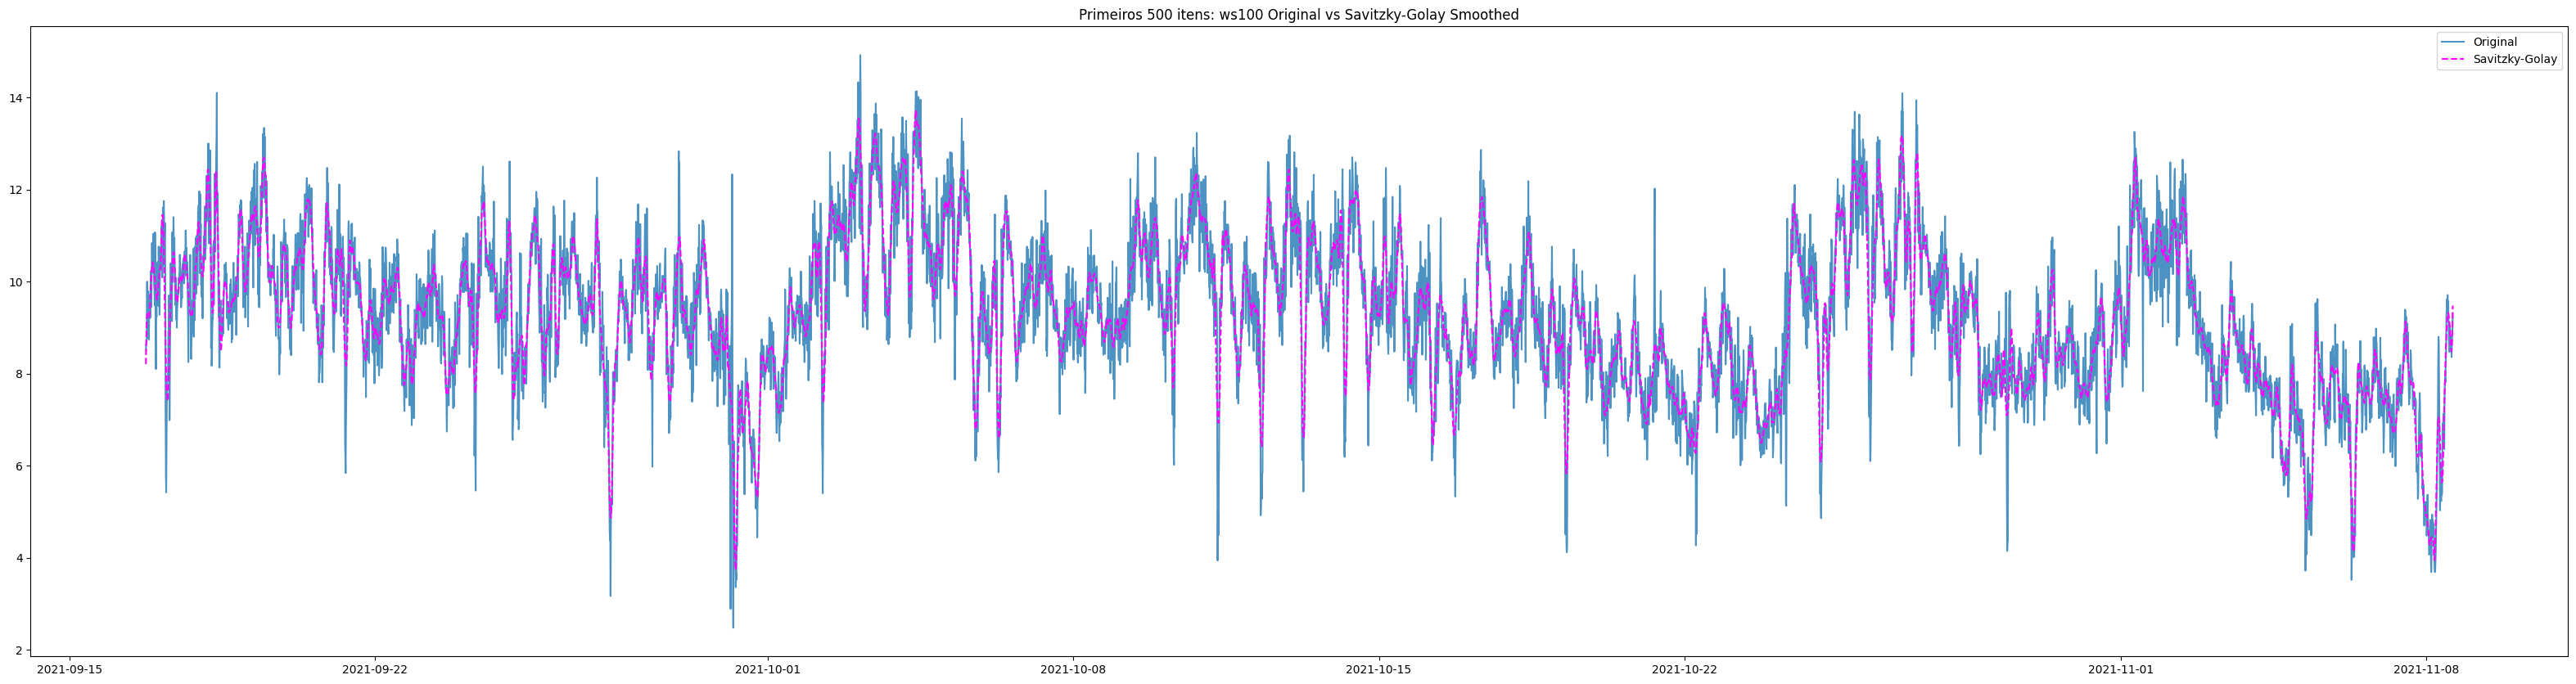

In [86]:

# Carregar o dataset
data = pd.read_csv("dataset.csv")
data.index = pd.to_datetime(data['id'], errors='ignore')
data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

# Inicializando variables como um DataFrame vazio
variables = pd.DataFrame(index=data.index)

# Aplicando o filtro Savitzky-Golay para suavizar as colunas
window_length = 37  # Deve ser ímpar e adequado ao tamanho dos seus dados
polyorder = 5

for col in ['ws100', 'humid', 'wdisp100', 'wdir100']:
    if col in data.columns:
        variables[f'{col}_savgol'] = savgol_filter(data[col], window_length=window_length, polyorder=polyorder)
    else:
        raise ValueError(f"A coluna {col} não existe no dataset.")

# Aplicando StandardScaler às colunas do DataFrame variables
# Separar a coluna 'ws100_savgol' para um scaler separado
scaler_ws100 = MinMaxScaler()
variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_savgol']])

# Escalar as demais variáveis
scaler_other = MinMaxScaler()
variables_scaled_other = scaler_other.fit_transform(variables.drop(columns=['ws100_savgol']))

# Combinar as variáveis escaladas
variables_scaled = np.hstack((variables_scaled_ws100, variables_scaled_other))
variables_scaled = pd.DataFrame(
    variables_scaled, 
    columns=variables.columns, 
    index=variables.index
)


plt.figure(figsize=(40, 10))
plt.plot(data.index[0:], data['ws100'][0:], label='Original', alpha=0.8)
plt.plot(variables.index[0:], variables['ws100_savgol'][0:], label='Savitzky-Golay', linestyle='--', color='magenta')
plt.title('Primeiros 500 itens: ws100 Original vs Savitzky-Golay Smoothed')
plt.legend()
plt.show()

# plt.figure(figsize=(80, 10))
# plt.plot(data.index[0:], data['humid'][0:], label='Original', alpha=0.8)
# plt.plot(variables.index[0:], variables['humid_savgol'][0:], label='Savitzky-Golay', linestyle='--', color='magenta')
# plt.title('Primeiros 500 itens: ws100 Original vs Savitzky-Golay Smoothed')
# plt.legend()
# plt.show()

# plt.figure(figsize=(80, 10))
# plt.plot(data.index[0:], data['wdisp100'][0:], label='Original', alpha=0.8)
# plt.plot(variables.index[0:], variables['wdisp_100'][0:], label='Savitzky-Golay', linestyle='--', color='magenta')
# plt.title('Primeiros 500 itens: ws100 Original vs Savitzky-Golay Smoothed')
# plt.legend()
# plt.show()

# plt.figure(figsize=(80, 10))
# plt.plot(data.index[0:], data['wdir100'][0:], label='Original', alpha=0.8)
# plt.plot(variables.index[0:], variables['wdir_100'][0:], label='Savitzky-Golay', linestyle='--', color='magenta')
# plt.title('Primeiros 500 itens: ws100 Original vs Savitzky-Golay Smoothed')
# plt.legend()
# plt.show()


In [87]:

input_steps = 36
output_steps = 6

# Criar sequências de treinamento
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  # Previsão apenas do ws100
    return np.array(X), np.array(y)

# Transformar variables_scaled em array
data_array = variables_scaled.values  # Dados não escalonados

# Criar as sequências para treino e teste
X, y = create_sequences(data_array, input_steps, output_steps)

# Dividir os dados em treinamento e teste (80% treino e 20% teste)
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
def custom_huber_loss(y_true, y_pred):
    delta = 0.2  # Delta pequeno
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

def build_model(input_steps, num_features, output_steps):
    num_layers = 1
    units = 64
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            kernel_regularizer=l2(1e-5),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
    
    # Contexto de Atenção
    context_vector = encoder_outputs  # Saídas do encoder para a atenção
    
    # Decoder
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :])  # Usar o último passo do encoder
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            kernel_regularizer=l2(1e-5),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
    
    # Aplicar Atenção
    # Atenção Multi-Head
    attention_layer = MultiHeadAttention(num_heads=4, key_dim=units, name='multihead_attention')
    attention_output = attention_layer(query=decoder_outputs, value=context_vector, key=context_vector)

    # Ajustar o Contexto da Atenção com uma Camada Dense
    attention_dense = Dense(units, activation='tanh', name='attention_dense')
    attention_output = attention_dense(attention_output)

    # Combinar com o Decoder
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Camada de Saída
    # Alteração: Usar TimeDistributed com Dense(1) e remover dimensões extras
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs)  # [batch, output_steps]
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=custom_huber_loss,
        metrics=['mae']
    )
    
    return model

In [89]:
# %%

num_features = X_train.shape[2]
model = build_model(input_steps, num_features, output_steps)


model.summary()

Model: "Bidirectional_LSTM_Seq2Seq_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 36, 128)   │     35,328 │ encoder_inputs[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm_0      │ (None, 36, 128)   │        256 │ bidirectional_12… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 128)       │          0 │ encoder_norm_0[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 6, 128)    │          0 │ get_item_11[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_0      │ (None, 6, 128)    │    131,584 │ repeat_vector_11… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_norm_0      │ (None, 6, 128)    │        256 │ decoder_lstm_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 6, 128)    │    131,968 │ encoder_norm_0[0… │
│ (MultiHeadAttentio… │                   │            │ decoder_norm_0[0… │
│                     │                   │            │ encoder_norm_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 6, 64)     │      8,256 │ multihead_attent… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 6, 192)    │          0 │ decoder_norm_0[0… │
│ (Concatenate)       │                   │            │ attention_dense[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        193 │ concatenate_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 6)         │          0 │ output_layer[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 307,841 (1.17 MB)

 Trainable params: 307,841 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# %%
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

# Treinar o modelo
history = model.fit(
    X_train, y_train, 
    epochs=100,  # Aumentar o número de épocas conforme necessário
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# %%
# Carregar o melhor modelo salvo
model.load_weights('best_model.h5.keras')

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Inverter a escala para os valores previstos e reais
# Como o scaler_ws100 foi ajustado em uma coluna, precisamos adaptar a forma para inversão
y_test_inversed = scaler_ws100.inverse_transform(y_test)
y_pred_inversed = scaler_ws100.inverse_transform(y_pred)


Epoch 1/100


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0159 - mae: 0.1268 - val_loss: 0.0036 - val_mae: 0.0382 - learning_rate: 1.0000e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0034 - mae: 0.0363 - val_loss: 0.0031 - val_mae: 0.0314 - learning_rate: 1.0000e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0034 - mae: 0.0364 - val_loss: 0.0032 - val_mae: 0.0323 - learning_rate: 1.0000e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0031 - mae: 0.0318 - val_loss: 0.0034 - val_mae: 0.0388 - learning_rate: 1.0000e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0033 - mae: 0.0375 - val_loss: 0.0028 - val_mae: 0.0268 - learning_rate: 1.0000e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0029 - mae: 0.0284 - val_loss: 0.0033 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0029 - mae: 0.0296 - val_loss: 0.0028 - val_mae: 0.0266 - le

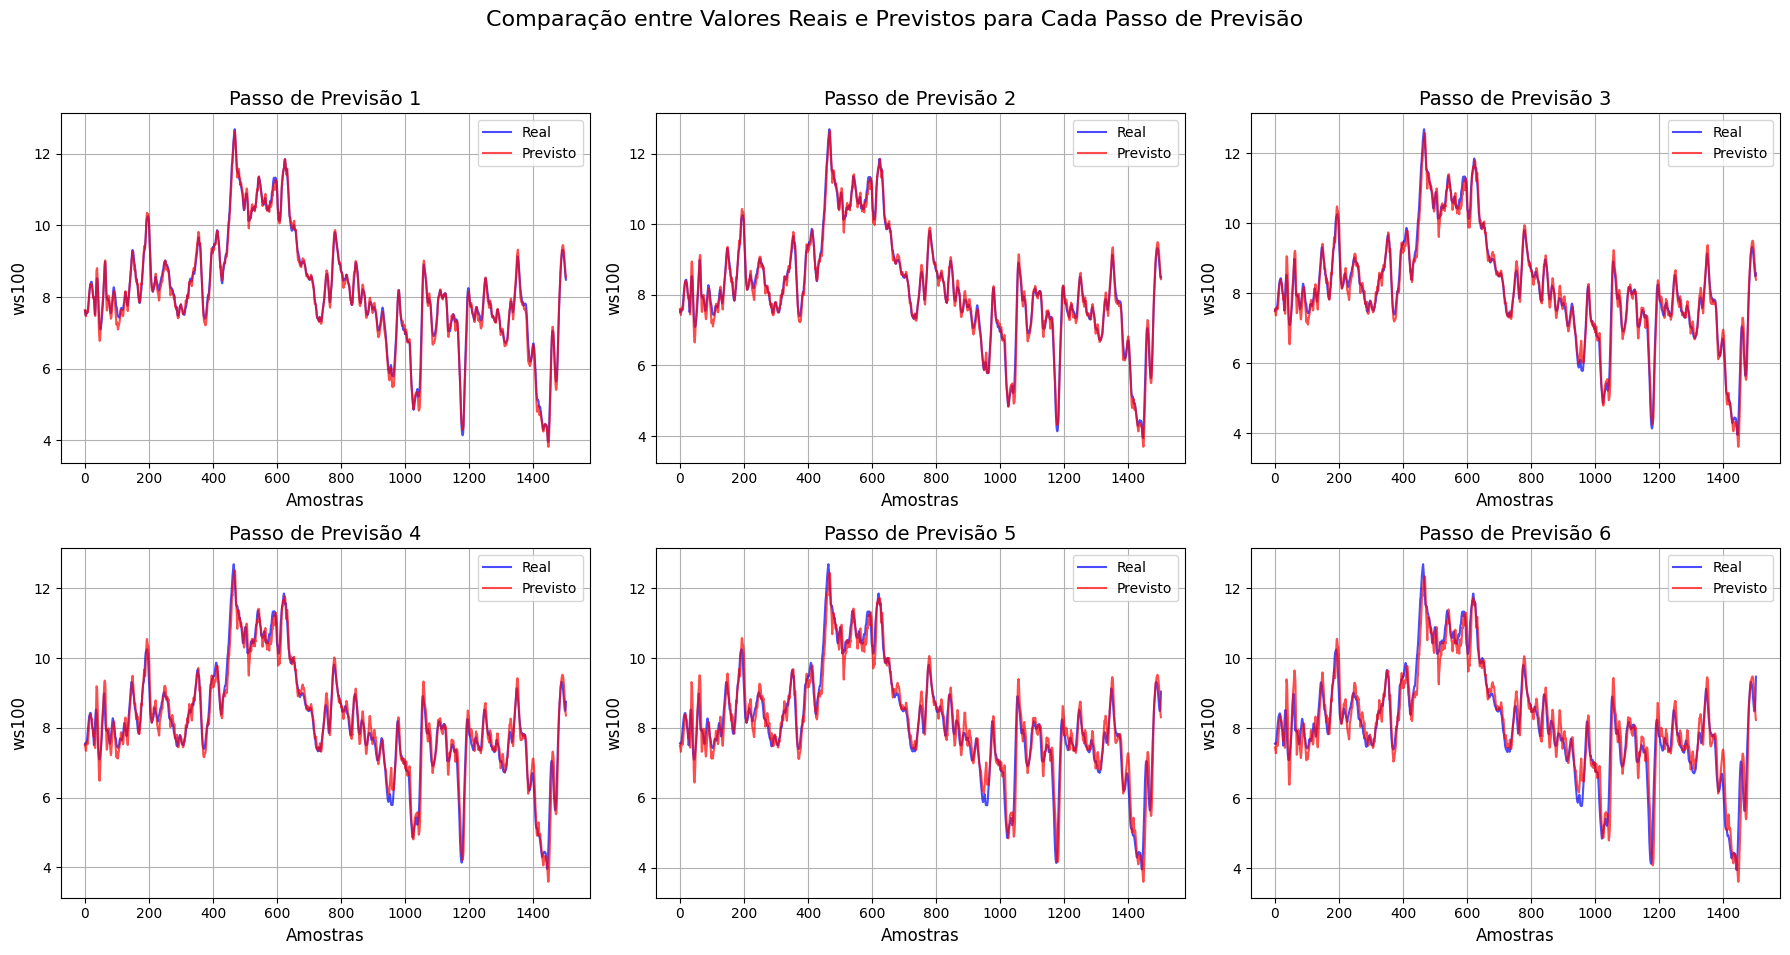

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Número de passos de previsão
output_steps = 6

# Criar uma figura com subplots 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    # Extrair os valores reais e previstos para o passo atual
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    # Plotar os valores reais e previstos
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    # Adicionar título e legendas
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    # Opcional: Adicionar a diferença (resíduo) como uma linha pontilhada
    # ax.plot(real - pred, label='Resíduo', color='green', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar o layout para não sobrepor o título
plt.show()